# Socratic Models for Multimodal Reasoning
## Introduction
In this notebook, we use the Socratic models approach applied to multimodal reasoning tasks, i.e, chain-of-thought (CoT) reasoning & visual question-answering (VQA)

### Imports

In [2]:

# global
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
from transformers import set_seed
import openai
from datasets import load_dataset
from dotenv import load_dotenv
load_dotenv()

# local 
sys.path.insert(0, '../')
import scripts.image_captioning as ic
from scripts.utils import get_device
# extensions
%load_ext autoreload
%autoreload 2

/opt/conda/envs/dl2-sm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-28 13:11:09.420096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Set seed & device

In [3]:
set_seed(42)    # set seed for reproducibility
# set the device to use
device = get_device()
print(f'Using device: {device}')

Using device: cuda


#### Class instantiation

In [4]:
# instantiate managers
clip_manager = ic.ClipManager(device=device)
image_manager = ic.ImageManager()
vocab_manager = ic.VocabManager()
prompt_generator = ic.LmPromptGenerator()

In [5]:
# setup lm
lm_model = 'gpt' # gpt or huggingface transformer model
# OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5, EleutherAI/gpt-neox-20b
lm_manager = ic.LmManager(version=lm_model, use_api=True, device=device)
openai.api_key = os.getenv('OPENAI_API_KEY')

#### Create image & text embeddings

In [6]:
# compute place & objects features
place_feats = clip_manager.get_text_emb([f'Photo of a {p}.' for p in vocab_manager.place_list])
obj_feats = clip_manager.get_text_emb([f'Photo of a {o}.' for o in vocab_manager.object_list])

## Chain-of-thought reasoning

### Data
We use the [ScienceQA](https://scienceqa.github.io/) dataset.

In [7]:
# load scienceQA dataset
scienceQA_dataset = load_dataset('derek-thomas/ScienceQA', split='validation')
# filter out samples with no image
scienceQA_dataset = [sample for sample in scienceQA_dataset if sample['image'] is not None]

Found cached dataset parquet (/home/neil/.cache/huggingface/datasets/derek-thomas___parquet/derek-thomas--ScienceQA-ca4903a3b5795914/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


#### Visualize dataset samples

In [ ]:
#TODO: delete this cell in final version
# viz samples
# for i, sample in enumerate(scienceQA_dataset[670:680]):
#     print(f'sample {i}:')
#     plt.figure(figsize=(4, 4))
#     plt.imshow(sample['image'])
#     plt.axis('off')
#     plt.show()
#     # sample['image'].show()
#     print('question:', sample['question'])
#     print('choices:', sample['choices'])
#     print('hint:', sample['hint'])
#     # print('lecture:', sample['lecture'])
#     print('answer:', sample['answer'])
#     print('solution:', sample['solution'])
#     print('-'*50)

# load sample idxs from json
# with open('../data/scienceqa/sample_idxs.json', 'r') as f:
#     sample_idxs_file = json.load(f)
#     sample_idxs = sample_idxs_file['vqa']
# for idx in sample_idxs[0:20]:
#     sample = scienceQA_dataset[idx]
#     print(f'sample {idx}:')
#     plt.figure(figsize=(4, 4))
#     plt.imshow(sample['image'])
#     plt.axis('off')
#     plt.show()
#     # sample['image'].show()
#     print('question:', sample['question'])
#     print('choices:', sample['choices'])
#     print('hint:', sample['hint'])
#     # print('lecture:', sample['lecture'])
#     print('answer:', sample['answer'])
#     # print('solution:', sample['solution'])
#     print('-'*50)

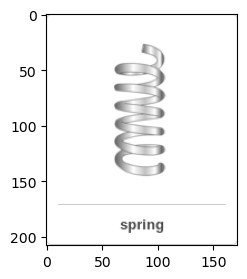

question: Which property matches this object?
choices: ['flexible', 'slippery']
answer: 0
solution: Look at the object.
Think about each property.
A flexible object can be folded or bent without breaking easily. The spring is flexible.
A slippery object is hard to hold onto or stand on. The spring is not slippery.


In [9]:
# select & viz sample
sample_idx = 142
sample = scienceQA_dataset[sample_idx]
plt.figure(figsize=(3, 3))
plt.imshow(sample['image'])
plt.show()
print(f'question: {sample["question"]}\nchoices: {sample["choices"]}\nanswer: {sample["answer"]}\nsolution: {sample["solution"]}')

### Zero-shot CoT reasoning
Generate prompts using image info (CLIP) and questions, hints and choices from the dataset, along with a sentence to induce zero-shot CoT reasoning. Generate outputs (solution + rationale) from LM.

In [128]:
# compose prompt
prompt = prompt_generator.create_cot_prompt(sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

prompt: This image was taken in a drugstore. It contains a spring, spring scale, coil, volute, sprig, set gun, whipping cream, elastic, spar, whisk.
Question: Which property matches this object?
Choices: ['flexible', 'slippery']
Hint: Select the better answer.
Answer: Let's think step by step...



In [129]:
# generate output
if lm_model == 'gpt':
    lm_params = {'max_tokens': 100, 'temperature': 1., 'n': 1}
    output = ic.get_response_gpt(prompt, **lm_params)
else:
    lm_params = {'max_new_tokens': 50, 'temperature': 1., 'do_sample': True, 'length_penalty': 2.} 
    output = lm_manager.generate_response(prompt, lm_params)

print(f'output: {output}\ngt solution: {sample["solution"]}\ngt answer: {sample["answer"]}')

output: The objects in the image include a spring, spring scale, coil, volute, sprig, set gun, whipping cream, elastic, spar, and whisk. None of these objects are explicitly described as slippery, so we can eliminate that option. However, there are several objects that could be described as flexible, such as the spring, coil, and elastic. Therefore, the correct answer is "flexible."
gt solution: Look at the object.
Think about each property.
A flexible object can be folded or bent without breaking easily. The spring is flexible.
A slippery object is hard to hold onto or stand on. The spring is not slippery.
gt answer: 0


### Few-shot CoT reasoning
Generate prompts using image info (CLIP) and questions, hints and choices from the dataset, along with previous prompts & solutions (rational + choice) to induce few-shot CoT reasoning. Generate outputs from LM.

example sample:


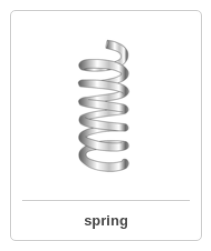

question: Which property matches this object?
choices: ['flexible', 'slippery']
answer: 0
solution: Look at the object.
Think about each property.
A flexible object can be folded or bent without breaking easily. The spring is flexible.
A slippery object is hard to hold onto or stand on. The spring is not slippery.
target sample:


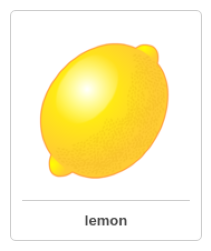

question: Which property matches this object?
choices: ['yellow', 'salty']
answer: 0
solution: Look at the object.
Think about each property.
Potato chips have a salty taste. The lemon is not salty.
Yellow is a color.
This color is yellow. The lemon is yellow.


In [10]:
# select & viz example & target samples
# candidate pairs: single-prop: 122, 142 | multi-prop: 340, 142, 
# sample example
eg_sample_idx, target_sample_idx = 142, 523
eg_sample, target_sample = scienceQA_dataset[eg_sample_idx], scienceQA_dataset[target_sample_idx]
# show example sample
print('example sample:')
plt.figure(figsize=(3, 3))
plt.imshow(eg_sample['image'])
plt.axis('off')
plt.show()
print(f'question: {eg_sample["question"]}\nchoices: {eg_sample["choices"]}\nanswer: {eg_sample["answer"]}\nsolution: {eg_sample["solution"]}')

# show target sample
print('target sample:')
plt.figure(figsize=(3, 3))
plt.imshow(target_sample['image'])
plt.axis('off')
plt.show()
print(f'question: {target_sample["question"]}\nchoices: {target_sample["choices"]}\nanswer: {target_sample["answer"]}\nsolution: {target_sample["solution"]}')

In [158]:
# generate prompt
prompt = prompt_generator.create_cot_prompt(eg_sample, clip_manager, vocab_manager, place_feats, obj_feats) + f'{eg_sample["solution"]}. So the answer is {eg_sample["choices"][eg_sample["answer"]]}\n' + prompt_generator.create_cot_prompt(target_sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

prompt: This image was taken in a drugstore. It contains a spring, coil spring, volute spring, spring balance, spring scale, coil, spiral, volute, whorl, helix, sprig, spiral, volute, spritzer, set gun, spring gun, annual, whipping cream, light whipping cream.
Question: Which property matches this object?
Choices: ['flexible', 'slippery']
Hint: Select the better answer.
Answer: Let's think step by step...Look at the object.
Think about each property.
A flexible object can be folded or bent without breaking easily. The spring is flexible.
A slippery object is hard to hold onto or stand on. The spring is not slippery.. So the answer is flexible
This image was taken in a ball pit. It contains a citron, lemon, lemon, lemon tree, Citrus limon, fruit drink, ade, vitamin C, C, ascorbic acid, citrus, citrus fruit, citrous fruit, vitamin B2, vitamin G, riboflavin, lactoflavin, ovoflavin, hepatoflavin, lime, lemon curd, lemon cheese, bergamot, bergamot orange, Citrus bergamia.
Question: Which pr

In [159]:
# generate outputs from LM
if lm_model == 'gpt':
    lm_params = {'max_tokens': 100, 'temperature': 1.}
    output = ic.get_response_gpt(prompt, **lm_params)
else:
    lm_params = {'max_new_tokens': 100, 'temperature': 1., 'do_sample': False, 'length_penalty': 2.} 
    output = lm_manager.generate_response(prompt, lm_params)
print(f'output: {output}\ngt solution: {target_sample["solution"]}\ngt answer: {target_sample["answer"]}')

output: Look at the object.
Think about each property.
The object is yellow, as it contains citrons, lemons, and limes which are all yellow fruits. It is not salty, as none of the items listed are salty. Therefore, the answer is yellow.
gt solution: Look at the object.
Think about each property.
Potato chips have a salty taste. The lemon is not salty.
Yellow is a color.
This color is yellow. The lemon is yellow.
gt answer: 0


## Visual question-answering (VQA)
Visual question-answering using VLM (CLIP) + LM
### Zero-shot VQA

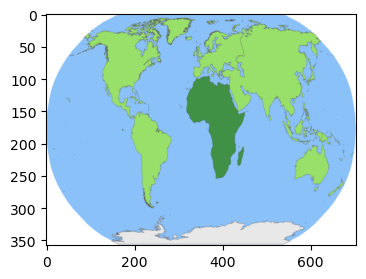

question: Which continent is highlighted?
choices: ['Asia', 'North America', 'Africa', 'South America']
answer: 2
solution: This continent is Africa.


In [18]:
# get sample
sample_idx = 148 # 134, 148
sample = scienceQA_dataset[sample_idx]
# show sample
plt.figure(figsize=(4, 3))
plt.imshow(sample['image'], aspect='auto')
plt.show()
print(f'question: {sample["question"]}\nchoices: {sample["choices"]}\nanswer: {sample["answer"]}\nsolution: {sample["solution"]}')

In [143]:
# compose prompt
prompt = prompt_generator.create_vqa_prompt(sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

prompt: This image was taken in a rainforest. It contains a Black African, region, African, geographical area, geographic area, geographical region, geographic region, region, part, asclepiad, North American, sphere, sphere of influence, map, South African. Using this information, answer the following question: Which continent is highlighted?
Hint: 
Select the index of the correct choice: ['0 Asia', '1 North America', '2 Africa', '3 South America']. Your answer should be a single integer (no text) and you must choose exactly one of the options.
Answer: 



In [144]:
# generate outputs from LM
if lm_model == 'gpt':
    lm_params = {'max_tokens': 20, 'temperature': 1.}
    output = ic.get_response_gpt(prompt, **lm_params)
else:
    lm_params = {'max_new_tokens': 20, 'temperature': 1., 'do_sample': False} 
    output = lm_manager.generate_response(prompt, lm_params)
print(f'output: {output}\ngt answer: {sample["answer"] }')

output: 2
gt answer: 2


### Few-shot VQA

example sample:


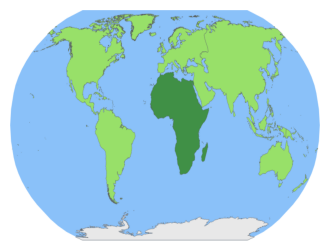

question: Which continent is highlighted?
choices: ['Asia', 'North America', 'Africa', 'South America']
answer: 2
target sample:


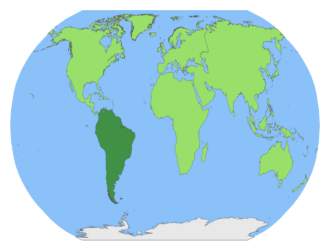

question: Which continent is highlighted?
choices: ['South America', 'Antarctica', 'North America']
answer: 0



In [19]:
# select & viz example & target samples
# sample example
eg_sample_idx, target_sample_idx = 148, 134
eg_sample, target_sample = scienceQA_dataset[eg_sample_idx], scienceQA_dataset[target_sample_idx]
# show example sample
print('example sample:')
plt.figure(figsize=(4, 3))
plt.imshow(eg_sample['image'], aspect='auto')
plt.axis('off')
plt.show()
print(f'question: {eg_sample["question"]}\nchoices: {eg_sample["choices"]}\nanswer: {eg_sample["answer"]}')

# show target sample
print('target sample:')
plt.figure(figsize=(4, 3))
plt.imshow(target_sample['image'], aspect='auto')
plt.axis('off')
plt.show()
print(f'question: {target_sample["question"]}\nchoices: {target_sample["choices"]}\nanswer: {target_sample["answer"]}\n')

In [146]:
# generate prompt
prompt = prompt_generator.create_vqa_prompt(eg_sample, clip_manager, vocab_manager, place_feats, obj_feats) + f'{eg_sample["answer"]}\n' + prompt_generator.create_vqa_prompt(target_sample, clip_manager, vocab_manager, place_feats, obj_feats)
print(f'prompt: {prompt}\n')

prompt: This image was taken in a rainforest. It contains a Black African, region, African, geographical area, geographic area, geographical region, geographic region, region, part, asclepiad, North American, sphere, sphere of influence, map, South African. Using this information, answer the following question: Which continent is highlighted?
Hint: 
Select the index of the correct choice: ['0 Asia', '1 North America', '2 Africa', '3 South America']. Your answer should be a single integer (no text) and you must choose exactly one of the options.
Answer: 2
This image was taken in a rainforest. It contains a Latin American, Latino, region, region, part, South American, North American, geographical area, geographic area, geographical region, geographic region, representation, earth, ground, district, territory, territorial dominion, dominion, map. Using this information, answer the following question: Which continent is highlighted?
Hint: 
Select the index of the correct choice: ['0 South 

In [148]:
# generate outputs from LM
if lm_model == 'gpt':
    lm_params = {'max_tokens': 100, 'temperature': 1.}
    output = ic.get_response_gpt(prompt, **lm_params)
else:
    lm_params = {'max_new_tokens': 100, 'temperature': 1., 'do_sample': False, 'length_penalty': 2.} 
    output = lm_manager.generate_response(prompt, lm_params)
print(f'output: {output}\ngt solution: {target_sample["solution"]}\ngt answer: {target_sample["answer"]}')

output: 0
gt solution: This continent is South America.
gt answer: 0
